In [1]:
# Import necessary libraries and set random seeds for reproducibility
import torch
torch.manual_seed(6)

# Device configuration
if torch.cuda.is_available():
    torch.cuda.manual_seed(6)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available
import random
random.seed(6)

import numpy as np
np.random.seed(6)

from pandas import read_csv
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

In [2]:
# Load IMDB reviews dataset
data = read_csv("data/IMDB dataset.csv")
data.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [3]:
# Initialize CountVectorizer to convert text data into a bag-of-words model
vectorizer = CountVectorizer(lowercase=True, max_features=10000)
X = vectorizer.fit_transform(data["review"])
# Get binary labels for sentiment analysis
Y = data["sentiment"].apply(lambda x: 1 if x == "positive" else 0).values

In [4]:
# Test the vectorizer by printing some feature names
print(vectorizer.get_feature_names_out()[9000:9020])
X.shape, Y.shape

['they' 'thick' 'thief' 'thieves' 'thin' 'thing' 'things' 'think'
 'thinking' 'thinks' 'third' 'thirds' 'thirst' 'thirteen' 'thirties'
 'thirty' 'this' 'tho' 'thomas' 'thompson']


((50000, 10000), (50000,))

In [5]:
# Convert the sparse matrix X to a dense tensor and Y to a tensor
X_tensor = torch.tensor(X.todense(), dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y, dtype=torch.float32).to(device)

# Create a TensorDataset for training
trainset= torch.utils.data.TensorDataset(X_tensor, Y_tensor)

batch_size = 128
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

In [ ]:
# Simple linear model for binary classification
get_net = lambda: torch.nn.Linear(10000, 1).to(device)

from math import ceil
from my_adam import My_adam, My_adamax

# Binary Cross-Entropy Loss with logits includes the sigmoid layer of the 
# logistic regression model for better numerical stability
criterion = torch.nn.BCEWithLogitsLoss().to(device)
optimizers = [My_adam, My_adamax, torch.optim.SGD, torch.optim.Adagrad, torch.optim.RMSprop]

n_batches = ceil(len(trainset)/batch_size)
n_epochs = 40

# Variables to store loss history
n_datatpoints = n_batches * n_epochs
losses = []

# Train the model with different optimizers
for get_opt in optimizers:
    net = get_net()
    optimizer = get_opt(net.parameters(), lr=0.001)
    loss_log = torch.zeros(n_datatpoints, device=device)
    for epoch in range(n_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_log[i + n_batches*epoch] = loss
    losses.append(loss_log.detach().cpu())

print('Finished Training')

Finished Training


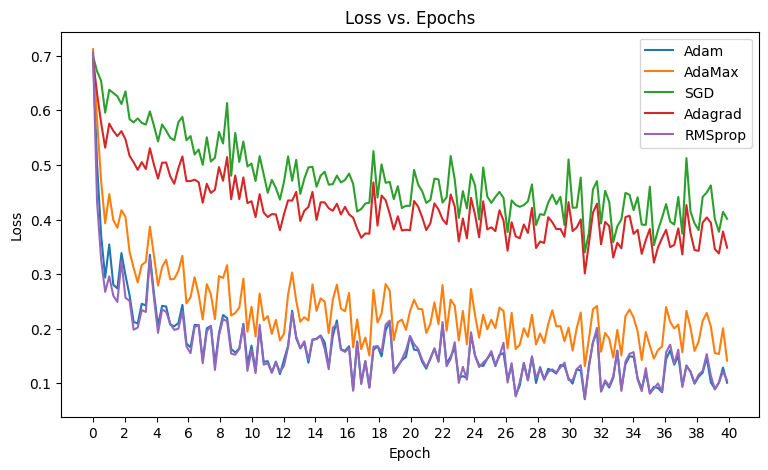

In [7]:
step = 100
x = np.arange(0, n_datatpoints, step)
plt.figure(figsize=(9, 5))
plt.plot(x,losses[0][::step], label='Adam')
plt.plot(x,losses[1][::step], label='AdaMax')
plt.plot(x,losses[2][::step], label='SGD')
plt.plot(x,losses[3][::step], label='Adagrad')
plt.plot(x,losses[4][::step], label='RMSprop')
plt.xticks(np.arange(0, n_datatpoints+1, n_batches*2), np.arange(0, n_epochs+1, 2))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()